In [ ]:
!git clone https://github.com/ultralytics/yolov5 --quiet  # clone
!cd yolov5 && pip install -r requirements.txt --quiet  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
!python yolov5/export.py --weights yolov5s6.pt --include onnx

export: data=yolov5/data/coco128.yaml, weights=['yolov5s6.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-82-g71621df torch 1.10.0+cu111 CPU

Fusing layers... 
YOLOv5s6 summary: 280 layers, 12612508 parameters, 0 gradients, 16.8 GFLOPs

PyTorch: starting from yolov5s6.pt with output shape (1, 25500, 85) (24.8 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success, saved as yolov5s6.onnx (48.5 MB)

Export complete (11.33s)
Results saved to /content
Detect:          python detect.py --weights yolov5s6.onnx
PyTorch Hub:     model = torch.hub.load('ultralytics/yolov5', 'custom', 'yolov5s6.onnx')
Validate:        python val.py --weights yolov5s6.onnx
Visualize:       https://netron.app


In [ ]:
!pip install tlcpack-nightly -f https://tlcpack.ai/wheels --quiet

In [ ]:
"""
from tvm.driver import tvmc

model = tvmc.load("./yolov5x.onnx", model_format="onnx")
tvmc.tune(model, target="llvm") #Step 1.5: Optional Tune
package = tvmc.compile(model, target="llvm") #Step 2: Compile
result = tvmc.run(package, device="cpu") #Step 3: Run
"""

'\nfrom tvm.driver import tvmc\n\nmodel = tvmc.load("./yolov5x.onnx", model_format="onnx")\ntvmc.tune(model, target="llvm") #Step 1.5: Optional Tune\npackage = tvmc.compile(model, target="llvm") #Step 2: Compile\nresult = tvmc.run(package, device="cpu") #Step 3: Run\n'

In [ ]:
!pip install --user onnx onnxoptimizer

In [ ]:
import onnx
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata

In [ ]:
model_path = "yolov5s6.onnx"
onnx_model = onnx.load(model_path)

In [ ]:
# iterate through inputs of the graph
for input in onnx_model.graph.input:
    print (input.name, end=": ")
    # get type of input tensor
    tensor_type = input.type.tensor_type
    # check if it has a shape:
    if (tensor_type.HasField("shape")):
        # iterate through dimensions of the shape:
        for d in tensor_type.shape.dim:
            # the dimension may have a definite (integer) value or a symbolic identifier or neither:
            if (d.HasField("dim_value")):
                print (d.dim_value, end=", ")  # known dimension
            elif (d.HasField("dim_param")):
                print (d.dim_param, end=", ")  # unknown dimension with symbolic name
            else:
                print ("?", end=", ")  # unknown dimension with no name
    else:
        print ("unknown rank", end="")
    print()

images: 1, 3, 640, 640, 


In [ ]:
from PIL import Image
import torch

img_url = "https://github.com/ultralytics/yolov5/blob/master/data/images/bus.jpg?raw=true"
img_path = download_testdata(img_url, "bus.jpg", module="data")
img = Image.open(img_path).resize((640, 640))
#x = np.array(img)[np.newaxis, :, :, :]
#x = np.transpose(x, axes=(0, 3, 1, 2))
x = np.array(img)

In [ ]:
import torchvision

x = torchvision.transforms.ToTensor()(x)
x = torch.unsqueeze(x, 0)
print(x.shape, type(x))

torch.Size([1, 3, 640, 640]) <class 'torch.Tensor'>


In [ ]:
target = "llvm"

input_name = "images"
shape_dict = {input_name: x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        "graph", mod, tvm.cpu(0), target, params
    ).evaluate()

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [ ]:
dtype = "float32"
tvm_output = executor(tvm.nd.array(x))

output = []
for i in range(len(tvm_output)):
  output.append(tvm_output[i].asnumpy())

print(len(output))

5


In [ ]:
import time
import torchvision
from torchvision.ops import box_iou

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, device="cpu",
                        labels=(), max_det=300):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping bounding boxes
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.030 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6), device=device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            break  # time limit exceeded

    return output


In [ ]:
import torch

print(torch.from_numpy(output[0]).shape)
out = non_max_suppression(torch.from_numpy(output[0]), conf_thres=0.7)[0] # BATCH SIZE is 1.

torch.Size([1, 25500, 85])


In [ ]:
print(out)

tensor([[ 5.2581e+02,  2.3270e+02,  6.3983e+02,  5.2163e+02,  9.1959e-01,
          0.0000e+00],
        [ 8.9985e+00,  1.3281e+02,  6.4120e+02,  4.5256e+02,  8.9624e-01,
          5.0000e+00],
        [ 4.2271e+01,  2.3580e+02,  1.8823e+02,  5.3448e+02,  8.8700e-01,
          0.0000e+00],
        [ 1.7734e+02,  2.3914e+02,  2.7221e+02,  5.1255e+02,  8.5073e-01,
          0.0000e+00],
        [-6.0644e-02,  3.2737e+02,  5.8518e+01,  5.1953e+02,  7.3827e-01,
          0.0000e+00]])


In [ ]:
import matplotlib.pyplot as plt

def plot(img, boxes):
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap='gray')
  fig.set_size_inches(width / 80, height / 80)

  for box in boxes:
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0)
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()

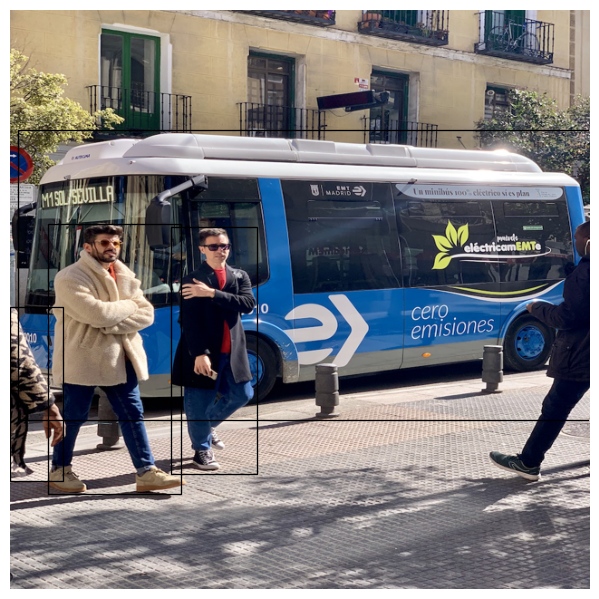

In [ ]:
plot(x[0], out[1:5])